In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

## Read Data

In [2]:
data = pd.read_csv("Brown_2006_data.csv")
data

,Bacteria,Attenuated,Virulent
0,1,608,570
1,2,200,218
2,3,49,81
3,4,35,84
4,5,20,53
5,6,17,36
6,7,3,13
7,8,8,29
8,9,6,8
9,10,2,18


Probability of bursting of i bacteria = $\delta_i$ <br>
Probability of surviving of i bacteria = $1 - \delta_i$ <br>
Bacterial division rate $ \alpha_i = r (1 - \delta_i) $ <br>
Burst rate $ \mu_i = ir\delta_i $

$ \frac{dM_1}{dt} = -rM_1 + \Sigma_{i \geq 1} (i+1)ir\delta_iM_i $ <br>
$ \forall i > 1, \frac{dM_1}{dt} = (i - 1)(1 - \delta_{i-1}) r M_{i-1} -i r M_i $

## 3(a)

Stationary distribution $ \pi_i = \frac {\Sigma_{n \geq i} B_n} {C i(i+1)} $    ----- (i) <br>
Stationary distribution with finite sum $ \pi_i = \frac {1 - \Sigma_{0 \leq n < i} B_n} {C i(i+1)} $    ----- (ii) <br>
Burst probabilities $ \delta_i = \frac {B_i} {\Sigma_{n \geq i} B_n} $          ----- (iii) <br>
$ B_n = P(N_b = n) = \delta_n \prod_{i < n} (1 - \delta_i) $   ----- (iv) <br>

From (i) & (iii): <br>
Stationary distribution $ \pi_i = \frac {B_i} {\delta_i C i(i+1)} $ 

From (ii) & (iv): <br>
Stationary distribution $ \pi_i = \frac {1 - \Sigma_{0 \leq n < i} \delta_n \prod_{i < n} (1 - \delta_i)} {C i(i+1)} $ 

In [3]:
def get_Bn(delta, n):
    product = 1
    for i in range(n):
        product *= (1 - delta[i])
    Bn = delta[n] * product
    return Bn

delta = np.array([0.1, 0.2, 0.3, 0.4])
get_Bn(delta, 0)

0.1

In [4]:
def stat_B(delta, N):
    C = 1.0
    pi = [0] * N
    for i in range(1, N):
        Bn = sum([get_Bn(delta, n) for n in range(i)])
        pi[i] = (1 - Bn) / (C * i * (i+1))
        #C += pi[i]
    return pi

delta = np.array([0.1, 0.2, 0.3, 0.4])
N = 4
pi = stat_B(delta, N)
pi

[0, 0.45, 0.12, 0.042]

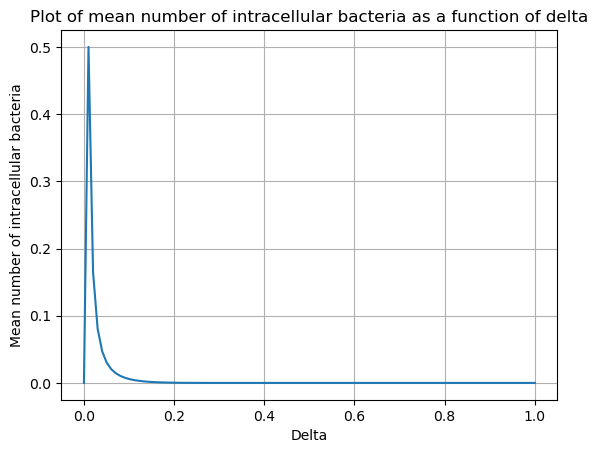

In [5]:
delta_0 = 0
delta_N = 1
N = 100
delta = np.linspace(delta_0, delta_N, N)
pi = stat_B(delta, N)

# Plot the mean number of intracellular bacteria as a function of delta for N=100
plt.plot(delta, pi)
plt.xlabel('Delta')
plt.ylabel('Mean number of intracellular bacteria')
plt.title('Plot of mean number of intracellular bacteria as a function of delta')
plt.grid(True)
plt.show()


## 3(b)

$ L(\pi) = X! \prod_{n \geq 1} \frac {\pi_n ^ {X_n}} {X_n!} $  ,  with $ X = \sum_{n \geq 1} X_n $ <br>
$ \log(L(\pi)) = \log(X!) + \log(\prod_{n \geq 1} \frac {\pi_n ^ {X_n}} {X_n!}) $ <br>
or, $ \log(L(\pi)) = \log(X!) + \sum_{n \geq 1} \log(\frac {\pi_n ^ {X_n}} {X_n!}) $ <br>
or, $ \log(L(\pi)) = \log(X!) + \sum_{n \geq 1} X_n \log(\pi_n) - \log(X_n!)) $

Since n! = 1 × 2 × 3 × … × n, <br>
log(n!) = log(1) + log(2) + log(3) + … + log(n).

In [6]:
def log_factorial(n):
    log_n_factorial = np.sum([np.log(i) for i in range(1, n+1)])
    return log_n_factorial

log_factorial(2000)

13206.524350513806

In [7]:
def log_lik(pi, obs):
    X = obs[:, 1]
    Xn = np.sum(X)
    X_factorial = log_factorial(Xn)

    summation = 0
    for n in range(len(pi)):
        if pi[n] > 0:
            summation += (np.log(pi[n]) * X[n]) - log_factorial(X[n])
        elif pi[n] == 0:
            summation += 1
        else:
            continue

    L = X_factorial + summation
    return L

pi = [0, 0.45, 0.05399999999999999, 0.0010205999999999998]
obs = np.array([[2, 3],
               [3, 2],
               [4, 7],
               [3, 4]])

log_lik(pi, obs)

-30.302374642590827

In [8]:
delta = np.linspace(0, 0.25, 29)
N = 29
pi = stat_B(delta, N)

strains = ['Attenuated', 'Virulent']
likelihoods = []
for strain in strains:
    obs = data[['Bacteria', strain]].values
    likelihoods.append(log_lik(pi, obs))

print(likelihoods)

[3848.6858472102736, 3657.5577477383963]


In [9]:
np.log(3847.6858472102736)

8.255227167914956

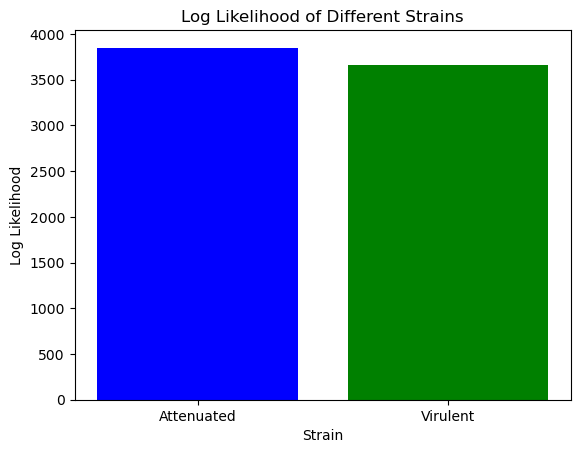

In [10]:
plt.bar(strains, likelihoods, color=['blue', 'green'])
plt.xlabel('Strain')
plt.ylabel('Log Likelihood')
plt.title('Log Likelihood of Different Strains')
plt.show()


In [11]:
from scipy.optimize import minimize

In [12]:
delta = np.linspace(0, 0.25, 29)
N = 29
pi = stat_B(delta, N)

# Negative log likelihood
def neg_log_likelihood(pi, obs):
    return -log_lik(pi, obs)

# Calculate MLE for each strain
def calculate_MLE(pi, strain_data):
    initial_guess = pi * strain_data[:, 1]  # Initial guess for theta
    #print(initial_guess)
    result = minimize(neg_log_likelihood, initial_guess, args=(strain_data,))
    return result.x

strain_data = data[['Bacteria', 'Attenuated']].values
theta_mle = calculate_MLE(pi, strain_data)
theta_mle

array([0.00000000e+00, 1.00000000e+02, 8.09375000e+00, 2.83900670e+00,
       9.47301214e-01, 5.17632449e-01, 6.23349400e-02, 1.17991136e-01,
       6.45264028e-02, 1.59779664e-02, 3.00559555e-02, 1.36861940e-02,
       6.96216188e-03, 7.99227767e-03, 0.00000000e+00, 0.00000000e+00,
       1.19407259e-03, 1.81953919e-03, 6.90450137e-04, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 1.59886489e-04,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00])

In [13]:
delta = np.linspace(0, 0.25, 29)
N = 29
pi = stat_B(delta, N)

# Negative log likelihood
def neg_log_likelihood(pi, obs):
    return -log_lik(pi, obs)

# Calculate MLE for each strain
def calculate_MLE(pi, strain_data):
    initial_guess = pi * strain_data[:, 1]  # Initial guess for theta
    #print(initial_guess)
    result = minimize(neg_log_likelihood, initial_guess, args=(strain_data,))
    return result.x

strain_data = data[['Bacteria', 'Virulent']].values
theta_mle = calculate_MLE(pi, strain_data)
theta_mle

array([0.00000000e+00, 1.09000000e+02, 1.33794643e+01, 6.81361607e+00,
       2.51034822e+00, 1.09616283e+00, 2.70118073e-01, 4.27717870e-01,
       8.60352037e-02, 1.43801698e-01, 2.40447644e-02, 5.01827114e-02,
       1.74054047e-02, 2.66409256e-03, 1.22453111e-02, 4.68765817e-03,
       2.38814518e-03, 0.00000000e+00, 6.90450137e-04, 2.08614577e-03,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       1.16888444e-04, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       3.07194906e-05])

## 4(a)

$ B_n = \frac {e ^ {-\theta} \theta ^ {n}} {n!} , 0 \leq n < N $ <br>
or, $ \log(B_n) = -\theta \log(e) + n\log(\theta) - log(n!) $ <br>
$ B_N = 1 - \sum_{0 \leq n < N} B_n $ <br>
$ B_0 = e ^ {-\theta} > 0 $

In [14]:
def log_likelihood(theta, N):
    Bn = [0] * N
    for n in range(N):
        Bn[n] = -theta[n] + n*np.log(theta[n]) - log_factorial(n)
    return Bn

# Test case
theta = [1.5, 2.5, 3.5, 4.5]  # Sample value for theta
N = 4  # Sample value for N

# Calculate log likelihood
likelihood_values = log_likelihood(theta, N)
likelihood_values

[-1.5, -1.583709268125845, -1.6876212435692093, -1.779527278899233]

In [15]:
# Negative log likelihood
def neg_log_likelihood(theta, N):
    return -np.sum(log_likelihood(theta, N))

neg_log_likelihood(theta, N)


6.5508577905942875

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


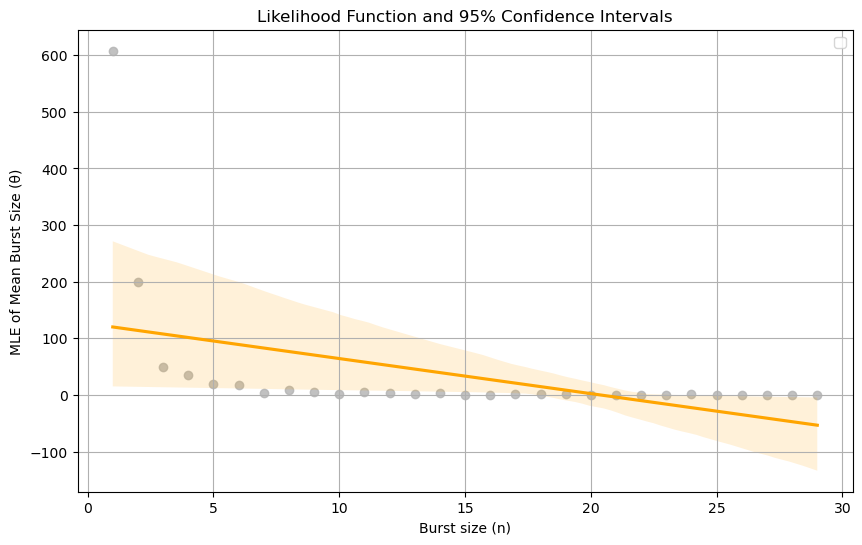

In [16]:
def log_likelihood(theta, N):
    Bn = np.zeros(N)
    for n in range(N):
        if theta[n] == 0:
            Bn[n] = 1
        elif theta[n] > 0:
            Bn[n] = -theta[n] + n*np.log(theta[n]) - log_factorial(n)
        else:
            continue
    return Bn

# Negative log likelihood
def neg_log_likelihood(theta, N):
    return -np.sum(log_likelihood(theta, N))

# Calculate MLE for each strain
def calculate_MLE(strain_data, N=100):
    initial_guess = np.ones(N)  # Initial guess for theta
    result = minimize(neg_log_likelihood, strain_data, args=(N,))
    return result.x

strain_data = data['Attenuated']
theta_mle = calculate_MLE(strain_data, N=29)

# Plot likelihood function and confidence interval
plt.figure(figsize=(10, 6))
# create regression plot
ax = sns.regplot(x = data['Bacteria'], y = theta_mle, ci = 95, 
                 marker="o", color=".7", line_kws=dict(color="orange"))
plt.xlabel('Burst size (n)')
plt.ylabel('MLE of Mean Burst Size (θ)')
plt.title('Likelihood Function and 95% Confidence Intervals')
plt.legend()
plt.grid(True)
plt.show()


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


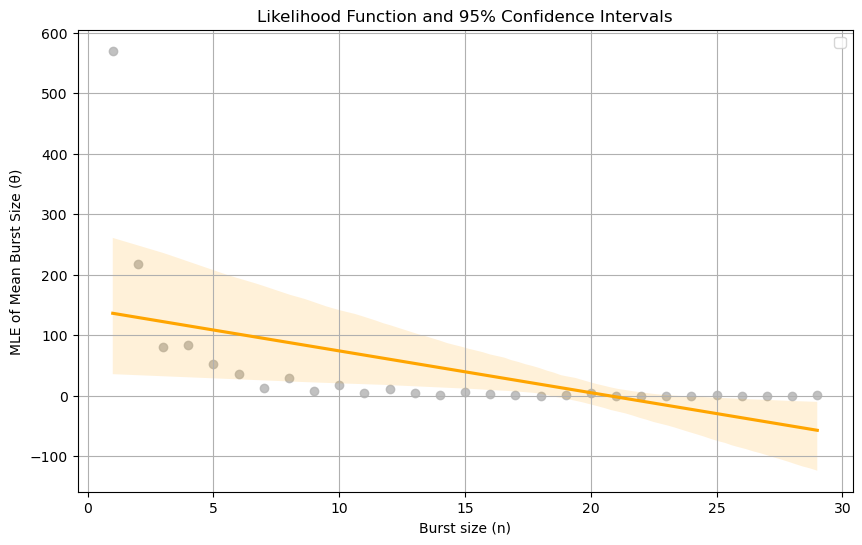

In [17]:
strain_data = data['Virulent']
theta_mle = calculate_MLE(strain_data, N=29)

# Plot likelihood function and confidence interval
plt.figure(figsize=(10, 6))
# create regression plot
ax = sns.regplot(x = data['Bacteria'], y = theta_mle, ci = 95, 
                 marker="o", color=".7", line_kws=dict(color="orange"))
plt.xlabel('Burst size (n)')
plt.ylabel('MLE of Mean Burst Size (θ)')
plt.title('Likelihood Function and 95% Confidence Intervals')
plt.legend()
plt.grid(True)
plt.show()


## 4(b)

In [18]:
from scipy.stats import poisson

In [19]:
# Define the AIC function
def calculate_aic(n, k, ll):
    return 2 * k - 2 * ll + (2 * k * (k + 1)) / (n - k - 1)

# Define the log-likelihood function for Model B
def log_likelihood_model_b(params, data):
    delta = params
    ll = np.sum(np.log(delta) * data)
    return -ll

# Define the log-likelihood function for Model C
def log_likelihood_model_c(params, data):
    theta = params
    ll = np.sum(poisson.logpmf(data, theta))
    return -ll

# Example data for observed intracellular bacteria
observed_data = {'Attenuated': data['Attenuated'].values,
                 'Virulent' : data['Virulent'].values}

# Initialize lists to store AIC values
aic_model_b = []
aic_model_c = []

# Calculate AIC for each strain
for strain, data in observed_data.items():
    # Model B (uniform bursting probability)
    res_model_b = minimize(log_likelihood_model_b, x0=[0.1], args=(data,), method='Nelder-Mead')
    ll_model_b = -res_model_b.fun
    aic_model_b.append(calculate_aic(len(data), 1, ll_model_b))
    
    # Model C (Poisson-distributed burst size)
    res_model_c = minimize(log_likelihood_model_c, x0=[np.mean(data)], args=(data,), method='Nelder-Mead')
    ll_model_c = -res_model_c.fun
    aic_model_c.append(calculate_aic(len(data), 1, ll_model_c))

# Print AIC values
print("AIC values for Model B:", aic_model_b)
print("AIC values for Model C:", aic_model_c)


AIC values for Model B: [-123677.53798386248, -147107.5406361999]
AIC values for Model C: [4158.233471445906, 3873.9940868320527]
